In [109]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [110]:
!ls "/content/drive/My Drive/diploma/"

datasets  diploma.ipynb  LICENSE  README.md  requirements.txt  trained_models


In [0]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader 
import torchvision
from torchvision import transforms, utils

In [112]:
print("Torch version: {}".format(torch.__version__))
print("Torchvision version: {}".format(torchvision.__version__))

Torch version: 1.0.1.post2
Torchvision version: 0.2.2


In [113]:
torch.cuda.is_available()

True

In [0]:
path_to_app = "/content/drive/My Drive/diploma/"

In [115]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

trainset = torchvision.datasets.CIFAR10(root=os.path.join(path_to_app, "datasets"), train=True,
                                        transform=data_transforms['train'], download=True)
trainset_loader = DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=os.path.join(path_to_app, "datasets"), train=False,
                                      transform=data_transforms['test'], download=True)
testset_loader = DataLoader(testset, batch_size=10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def imshow(images):
    images = images / 2 + 0.5
    np_img = images.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

In [0]:
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

In [118]:
print('Images shape {}'.format(images.size()))
print('Labels shape {}'.format(labels.shape))

Images shape torch.Size([10, 3, 32, 32])
Labels shape torch.Size([10])


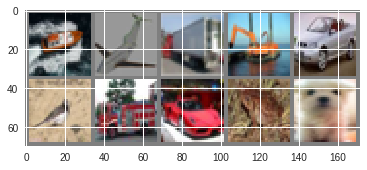

ship plane truck ship car bird truck car frog dog


In [119]:
# Show 10 images
imshow(utils.make_grid(images, nrow=5))
print(' '.join('%s' % classes[labels[j]] for j in range(len(labels))))

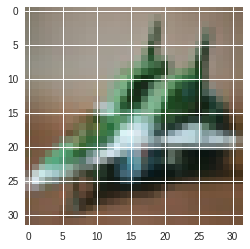

plane


In [120]:
# Show 1 image
images, labels = dataiter.next()
imshow(images[0])
print(classes[labels[0]])

In [0]:
import torch.nn as nn

In [0]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            # Input: (32x32x3)
            # Output (32x32x32)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # Output: (32x32x64)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Output: (16x16x64)
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer block2
            
            # Output: (16x16x128)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Output: (16x16x128)
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Output: (8x8x128)
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer block2
            
            # Output: (8x8x256)
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # Output: (8x8x256)
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Output: (4x4x256)
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            # 4096 = 4*4*256
            nn.Linear(in_features=4096, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=10)
        )
        
    def forward(self, x):
        
        x = self.conv_layer(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x = self.fc_layer(x)
        
        return x

In [0]:
import time

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time() 
    
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}:\n".format(epoch+1, num_epochs))
        
        # Each epoch has a train and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                # Set model to training mode
                model = model.train()
            else:
                # Set model to evaluate mode
                model = model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for _, data in enumerate(dataloaders[phase]):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                # Trach history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, predicted = torch.max(outputs, 1)
                    
                    # Backward + optimize if only in train
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predicted == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print("{} Loss: {:.4f} | Accuracy: {:.4f}\n".format(phase, epoch_loss, epoch_acc))
            
            # Update accuracy history
            if phase == "train":
                train_acc_history.append(epoch_acc)
            elif phase == "val":
                val_acc_history.append(epoch_acc)
                
            
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    
    return model, train_acc_history, val_acc_history

In [129]:
# Initialize Net
net = CNN()
print(net)

# Net's parameters
params = list(net.parameters())
print("Net's total parameters: {}".format(len(params)))
# Conv2d's (0) weights
print("First layer's weights size: {}".format(params[0].size()))

# Parameters for training
num_epochs = 5

# Dataloaders for training and validation phases
dataloaders_dict = {
    "train": trainset_loader,
    "val": testset_loader
}

from torch import optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), 0.001)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace)
    (15): Conv2d(256, 256, kern

In [130]:
# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [131]:
# Send the model to device
net = net.to(device)

net, train_acc_history, val_acc_history = train_model(net, dataloaders_dict, criterion, optimizer, num_epochs)

Epoch 1/5:

train Loss: 1.8188 | Accuracy: 0.3178

val Loss: 1.4307 | Accuracy: 0.4600

Epoch 2/5:

train Loss: 1.3936 | Accuracy: 0.4939

val Loss: 1.1098 | Accuracy: 0.6074

Epoch 3/5:

train Loss: 1.1364 | Accuracy: 0.6014

val Loss: 0.9618 | Accuracy: 0.6641

Epoch 4/5:

train Loss: 1.0050 | Accuracy: 0.6571

val Loss: 0.8647 | Accuracy: 0.6962

Epoch 5/5:

train Loss: 0.9149 | Accuracy: 0.6896

val Loss: 0.7945 | Accuracy: 0.7287

Training complete in 9m 2s


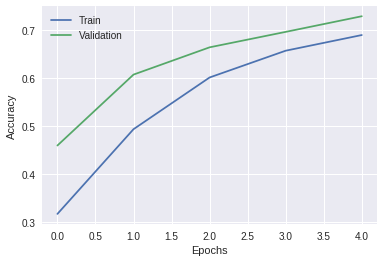

In [148]:
# Plot train/validation accuracy
plt.plot(train_acc_history, label="Train")
plt.plot(val_acc_history, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")

In [0]:
def save_model(model, path):
  torch.save(model.state_dict(), path)

In [0]:
save_model(net, os.path.join(path_to_app, "trained_models", "net_5e_072acc.pt"))

In [0]:
net_15 = CNN()
net_15 = net_15.to(device)

optimizer_15 = optim.Adam(net_15.parameters(), lr=0.001)

In [135]:
net_15, train_hist_15, val_hist_15 = train_model(net_15, dataloaders_dict, criterion, optimizer_15, 15)

Epoch 1/15:

train Loss: 1.7131 | Accuracy: 0.3536

val Loss: 1.3466 | Accuracy: 0.4930

Epoch 2/15:

train Loss: 1.2733 | Accuracy: 0.5432

val Loss: 1.0841 | Accuracy: 0.6228

Epoch 3/15:

train Loss: 1.0646 | Accuracy: 0.6273

val Loss: 0.9155 | Accuracy: 0.6778

Epoch 4/15:

train Loss: 0.9531 | Accuracy: 0.6730

val Loss: 0.8262 | Accuracy: 0.7139

Epoch 5/15:

train Loss: 0.8816 | Accuracy: 0.6988

val Loss: 0.8295 | Accuracy: 0.7124

Epoch 6/15:

train Loss: 0.8260 | Accuracy: 0.7221

val Loss: 0.7766 | Accuracy: 0.7383

Epoch 7/15:

train Loss: 0.7866 | Accuracy: 0.7357

val Loss: 0.6989 | Accuracy: 0.7636

Epoch 8/15:

train Loss: 0.7504 | Accuracy: 0.7499

val Loss: 0.6857 | Accuracy: 0.7717

Epoch 9/15:

train Loss: 0.7287 | Accuracy: 0.7583

val Loss: 0.6838 | Accuracy: 0.7658

Epoch 10/15:

train Loss: 0.7056 | Accuracy: 0.7686

val Loss: 0.6822 | Accuracy: 0.7700

Epoch 11/15:

train Loss: 0.6837 | Accuracy: 0.7757

val Loss: 0.6535 | Accuracy: 0.7854

Epoch 12/15:

train

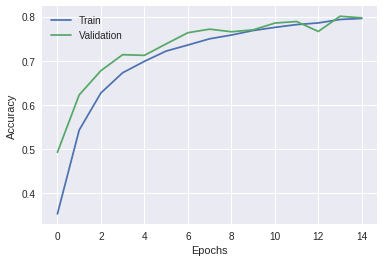

In [147]:
# Plot train/validation accuracy
plt.plot(train_hist_15, label="Train")
plt.plot(val_hist_15, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")

In [0]:
save_model(net_15, os.path.join(path_to_app, "trained_models", "net_15e_080acc.pt"))

In [0]:
net_25 = CNN()
net_25 = net_25.to(device)

optimizer_25 = optim.Adam(net_25.parameters(), lr=0.001)

In [138]:
net_25, train_acc_hist_25, val_acc_hist_25 = train_model(net_25, dataloaders_dict, criterion, optimizer_25, 25)

Epoch 1/25:

train Loss: 1.7327 | Accuracy: 0.3507

val Loss: 1.3176 | Accuracy: 0.5237

Epoch 2/25:

train Loss: 1.2765 | Accuracy: 0.5463

val Loss: 1.0205 | Accuracy: 0.6403

Epoch 3/25:

train Loss: 1.0622 | Accuracy: 0.6323

val Loss: 0.9220 | Accuracy: 0.6799

Epoch 4/25:

train Loss: 0.9431 | Accuracy: 0.6826

val Loss: 0.8117 | Accuracy: 0.7240

Epoch 5/25:

train Loss: 0.8709 | Accuracy: 0.7058

val Loss: 0.7912 | Accuracy: 0.7341

Epoch 6/25:

train Loss: 0.8164 | Accuracy: 0.7277

val Loss: 0.7181 | Accuracy: 0.7572

Epoch 7/25:

train Loss: 0.7814 | Accuracy: 0.7400

val Loss: 0.7316 | Accuracy: 0.7555

Epoch 8/25:

train Loss: 0.7427 | Accuracy: 0.7541

val Loss: 0.7104 | Accuracy: 0.7700

Epoch 9/25:

train Loss: 0.7147 | Accuracy: 0.7656

val Loss: 0.6816 | Accuracy: 0.7654

Epoch 10/25:

train Loss: 0.6895 | Accuracy: 0.7739

val Loss: 0.6490 | Accuracy: 0.7879

Epoch 11/25:

train Loss: 0.6715 | Accuracy: 0.7797

val Loss: 0.6602 | Accuracy: 0.7853

Epoch 12/25:

train

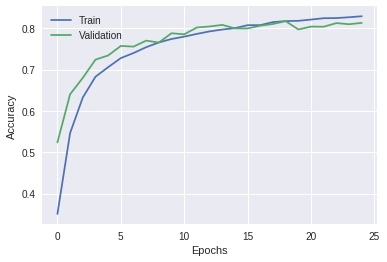

In [149]:
# Plot train/validation accuracy
plt.plot(train_acc_hist_25, label="Train")
plt.plot(val_acc_hist_25, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")

In [0]:
save_model(net_25, os.path.join(path_to_app, "trained_models", "net_25e_081acc.pt"))